In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter
import pickle
from scipy.signal import convolve
import matplotlib.image as image
import sys
import matplotlib.colors as colors
import matplotlib.cm as cmx
import os
from scipy.fft import fft, fftfreq


# impulse and step response of FB network and how they change with parameter

In [2]:

home = os.path.expanduser("~")


sys.path.insert(1, f'{home}/Documents/Repositories/motion_anticipation_network/model')
from utils import  DOG


In [3]:
#make impulse stimulus
def impulse_stimulus(length = 1.,impulse_timepoint = 0, amplitude = 1, dt = 0.001):


    tps = int(length/dt)
    barstim = np.zeros(tps)


    impulse_idx = int(impulse_timepoint/dt)
    barstim[impulse_idx] = amplitude

    #timeline = np.arange(0,length,self.dt)

    return barstim


def step_stimulus(length = 5.,start = 1.0, stop = 3.0, amplitude = 1, dt = 0.001):



    stimulus = (np.heaviside(np.arange(-start,length - start, dt), 1) - 1 * np.heaviside(
    np.arange(-stop, length - stop, step = dt),1)) * (amplitude)  


    #timeline = np.arange(0,length,self.dt)

    return stimulus


def main_frequency(signal, sampling_rate):
    """
    Calculate the main frequency of a signal.

    Parameters:
    signal (numpy array): The input signal (time domain).
    sampling_rate (float): The sampling rate of the signal in Hz.

    Returns:
    float: The main frequency of the signal in Hz.
    """
    # Number of samples in the signal
    N = len(signal)

    # Perform the Fast Fourier Transform (FFT)
    fft_values = fft(signal)

    # Get the corresponding frequencies
    frequencies = fftfreq(N, d=1/sampling_rate)

    # Only consider the positive frequencies (as FFT produces symmetric output)
    positive_frequencies = frequencies[:N // 2]
    positive_fft_values = np.abs(fft_values[:N // 2])

    # Find the frequency with the maximum amplitude in the FFT result
    main_freq_index = np.argmax(positive_fft_values)
    main_freq = positive_frequencies[main_freq_index]

    return main_freq



# load impulse and step simulations with feedback 

In [4]:
data = {}
cell =50


net = 'fb_linear'
step_stops = [1.5,2.,3.]



fp = f'{home}/Documents/Simulations/motion_anticipation_network/{net}'



with open(f'{fp}/params', 'rb') as handle:
    params = pickle.load(handle)    
 

with open(f'{fp}/out_impulse', 'rb') as handle:
    out_impulse = pickle.load(handle)    

out_steps= []
stim_steps= []
time_steps= []

for step_stop in step_stops:
    with open(f'{fp}/out_step_{step_stop}', 'rb') as handle:
        out_step = pickle.load(handle)
        out_steps.append( out_step ) 

    stim_steps.append(step_stimulus(dt = params['dt'],stop = step_stop))
    time_steps.append(np.arange(0,len(out_step['VG']))*params['dt'])






time_impulse = np.arange(0,len(out_impulse['VG']))*params['dt']


stim_impulse = impulse_stimulus(dt = params['dt'])


# Figure Parameter

In [5]:
fontsize_legend = 20
fontsize_labels = 25
fontsize_panellabel = 30
fontsize_ticks = 20
lw = 4
ms = 60

figsize_ratio = 3

figsize = (8,8)
image_format = "png"
dpi = 300
panellabel_position = [-0.07, .85]


# Impulse response

In [6]:
%matplotlib inline

Text(0.5, 0, 'time [s]')

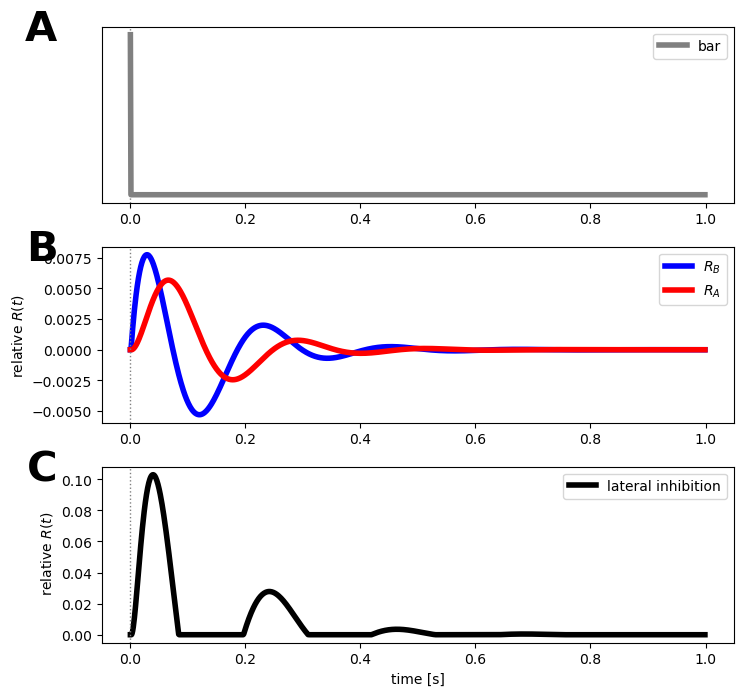

In [7]:
cbar = 'grey'
c1 = 'blue'
c2 = 'red'
speed_plot = -3

#initialize figure
nrows = 3
ncols = 1

fig = plt.figure(figsize=figsize)
fig.patch.set_facecolor('white')


gs = fig.add_gridspec(nrows,ncols)



fig.subplots_adjust(top=0.88,
bottom=0.11,
left=0.11,
right=0.9,
hspace=0.25,
wspace=0.48)





ax = fig.add_subplot(gs[0])

ax.text(panellabel_position[0]-0.0,panellabel_position[1]+0.25, "A", transform=ax.transAxes,
          fontsize=fontsize_panellabel, fontweight='bold', va='top', ha='right')


ax.plot(time_impulse, stim_impulse, linewidth = lw, color = cbar, label = 'bar')
# ax.plot(time_impulse ,out_impulse['inp'], linewidth = lw, color = 'k', label = 'V_drive')
#ax.plot(time_impulse,out_impulse['F'], label = '$V_{drive}$', color = 'k', linewidth = lw)
ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')
#ax.set_ylabel('$V(t)')
ax.legend()
ax.set_yticks([])


ax = fig.add_subplot(gs[1])


ax.text(panellabel_position[0]-0.0,panellabel_position[1]+0.25, "B", transform=ax.transAxes,
          fontsize=fontsize_panellabel, fontweight='bold', va='top', ha='right')



RB =out_impulse['RB'][cell,:]
RA = out_impulse['RA'][cell,:]   

ax.plot(time_impulse,RB, color = c1, linewidth = lw, label = '$R_{B}$')

ax.plot(time_impulse,RA, color = c2, linewidth = lw, label = '$R_{A}$')

#ax.plot(xdata,data[net_pool]['RB'][speed_plot], label = f'RB without lateral connectivity', color = c1, linestyle = ':', linewidth = lw)

ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')
ax.set_ylabel('relative $R(t)$')
ax.legend()


# add panel with all BC responses that the GC pools over
ax = fig.add_subplot(gs[2])


ax.text(panellabel_position[0]-0.0,panellabel_position[1]+0.25, "C", transform=ax.transAxes,
          fontsize=fontsize_panellabel, fontweight='bold', va='top', ha='right')


RG =out_impulse['RG']
ax.plot(time_impulse,RG, color = 'k', linewidth = lw, label = 'lateral inhibition')

ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')
ax.legend()
ax.set_ylabel(' relative $R(t)$')
ax.set_xlabel('time [s]')


# Step response

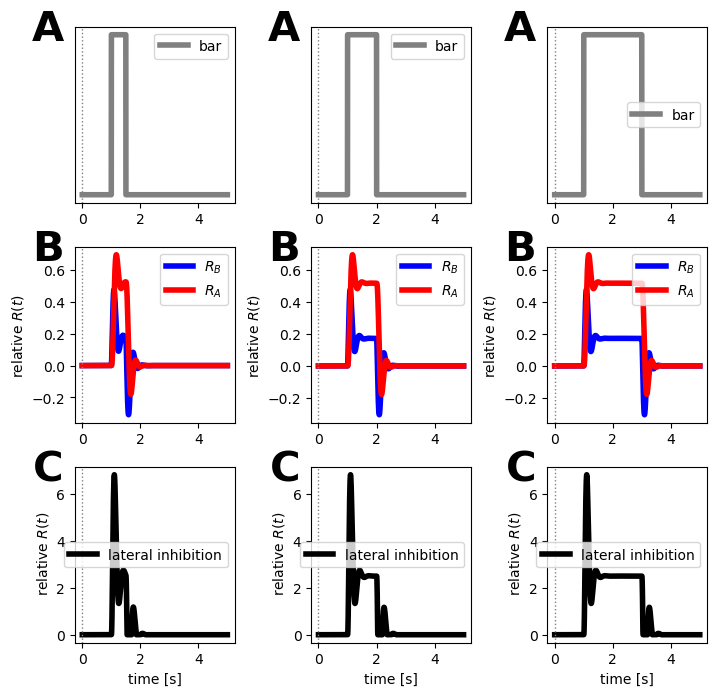

In [8]:
cbar = 'grey'
c1 = 'blue'
c2 = 'red'
speed_plot = -3


#initialize figure
nrows = 3
ncols = len(step_stops)

fig = plt.figure(figsize=figsize)
fig.patch.set_facecolor('white')


gs = fig.add_gridspec(nrows,ncols)



fig.subplots_adjust(top=0.88,
bottom=0.11,
left=0.11,
right=0.9,
hspace=0.25,
wspace=0.48)



for x,step_stop in enumerate(step_stops):

    ax = fig.add_subplot(gs[0,x])

    ax.text(panellabel_position[0]-0.0,panellabel_position[1]+0.25, "A", transform=ax.transAxes,
            fontsize=fontsize_panellabel, fontweight='bold', va='top', ha='right')

    out_step = out_steps[x]
    stim_step = stim_steps[x]
    time_step = time_steps[x]


    ax.plot(time_step ,stim_step, linewidth = lw, color = cbar, label = 'bar')
    # ax.plot(time_step ,out_step['inp'], linewidth = lw, color = cbar, label = 'bar')
    # ax.plot(time_step,out_step['F'], label = '$V_{drive}$', color = 'k', linewidth = lw)
    ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')
    #ax.set_ylabel('$V(t)')
    ax.legend()
    ax.set_yticks([])


    ax = fig.add_subplot(gs[1,x])


    ax.text(panellabel_position[0]-0.0,panellabel_position[1]+0.25, "B", transform=ax.transAxes,
            fontsize=fontsize_panellabel, fontweight='bold', va='top', ha='right')



    RB =out_step['RB'][cell,:]
    RA = out_step['RA'][cell,:]   

    ax.plot(time_step,RB, color = c1, linewidth = lw, label = '$R_{B}$')

    ax.plot(time_step,RA, color = c2, linewidth = lw, label = '$R_{A}$')

    #ax.plot(xdata,data[net_pool]['RB'][speed_plot], label = f'RB without lateral connectivity', color = c1, linestyle = ':', linewidth = lw)

    ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')
    ax.set_ylabel('relative $R(t)$')
    ax.legend()


    # add panel with all BC responses that the GC pools over
    ax = fig.add_subplot(gs[2,x])


    ax.text(panellabel_position[0]-0.0,panellabel_position[1]+0.25, "C", transform=ax.transAxes,
            fontsize=fontsize_panellabel, fontweight='bold', va='top', ha='right')


    RG =out_step['RG']
    ax.plot(time_step,RG, color = 'k', linewidth = lw, label = 'lateral inhibition')

    ax.axvline(0, linewidth = 1, color = cbar, linestyle = ':')
    ax.legend()
    ax.set_ylabel(' relative $R(t)$')
    ax.set_xlabel('time [s]')


# plot for multiple values of feedback weight wBA

-> with incresasing coupling strength impulse response changes from oni- to bi- to tri- and polyphasic

-> frequency increases with increasing weight 

-> step response changes from sustained to transient to osscillating

In [9]:
param = 'wBA'
vals =[0.,1.,3.,5.,10.,15.,20.,30.] #[46.0]        # values to test 


Text(0.5, 0, 'time')

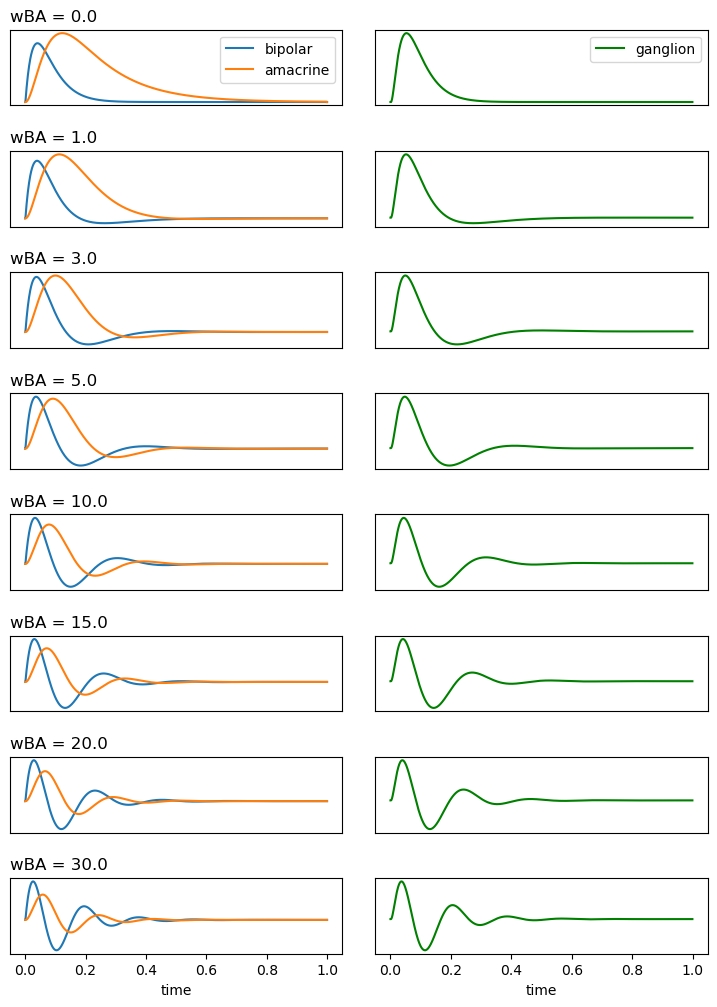

In [10]:
fig = plt.figure(figsize = (9,12))

fig.subplots_adjust(hspace = 0.6,
                    wspace = 0.1)

gs = fig.add_gridspec(len(vals),2)

amp = []
freq = []
for i,val in enumerate(vals): 

    # load output 
    with open(f'{fp}/{param}/{param}_{val}/out_impulse', 'rb') as handle:
        out_impulse = pickle.load(handle)    


    # plot bc and ac
    ax0 = fig.add_subplot(gs[i,0]) 
    ax0.set_title(f'wBA = {val}', loc = 'left')

    plt.plot(time_impulse,out_impulse['VB'][50,:], label = 'bipolar')
    plt.plot(time_impulse,out_impulse['VA'][50,:], label = 'amacrine') 


    # plot GC
    ax1 = fig.add_subplot(gs[i,1]) 
    plt.plot(time_impulse, out_impulse['VG'], color = 'green', label = 'ganglion')
    
    amp.append(np.max(out_impulse['VG']))

    frequency = main_frequency( out_impulse['VG'], 1/params['dt'])
    freq.append(frequency)
    
    if i ==0:
        ax0.legend()
        ax1.legend()

    if  i < len(vals)-1:
        ax0.set_xticks([])
        ax1.set_xticks([])
    ax0.set_yticks([])
    ax1.set_yticks([])



ax0.set_xlabel('time')
ax1.set_xlabel('time')



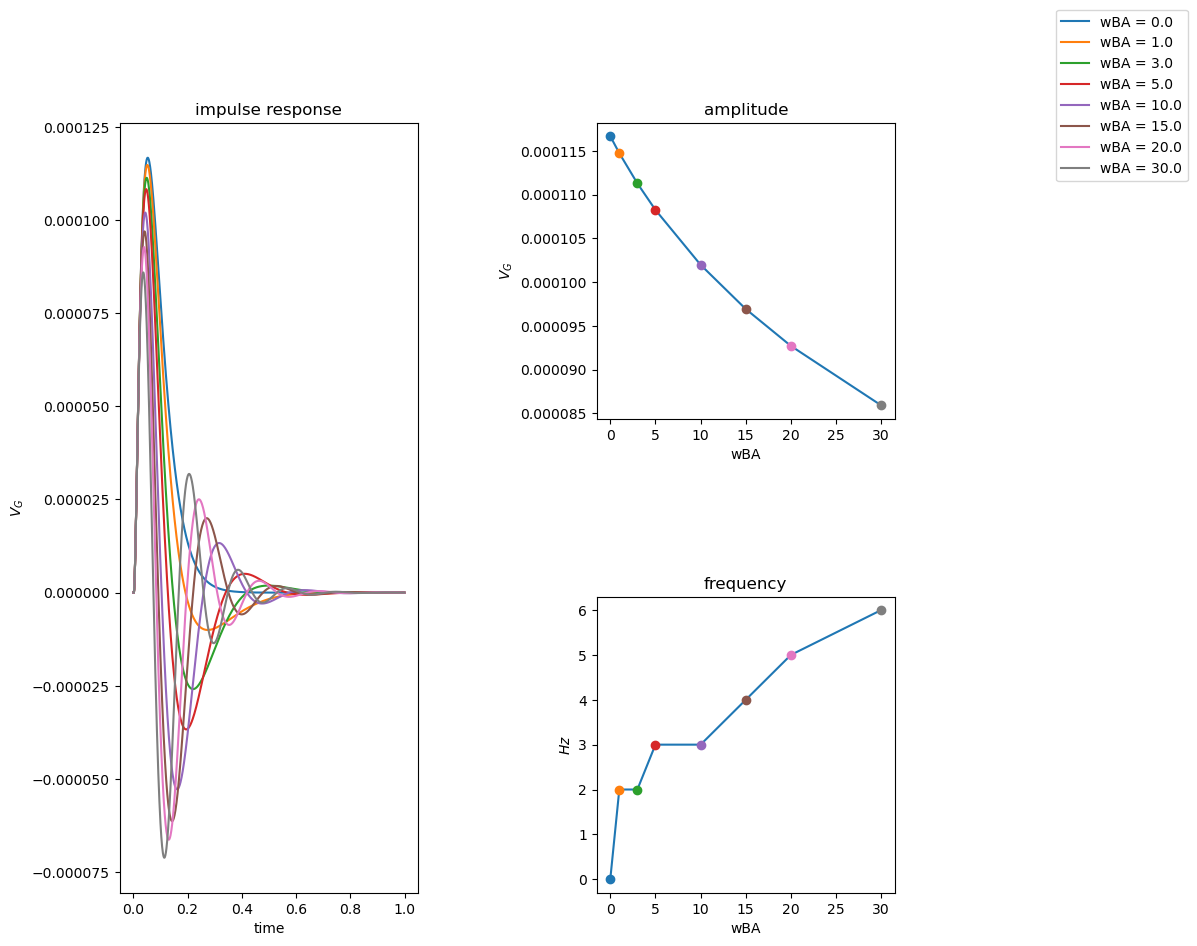

In [11]:
fig = plt.figure(figsize = (10,10))

gs = fig.add_gridspec(2,2)
ax0 = fig.add_subplot(gs[:,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[1,1])

fig.subplots_adjust(hspace = 0.6,
                    wspace = 0.6)

ax1.plot(vals,amp)
ax2.plot(vals,freq)



for i,val in enumerate(vals): 

    # load output 
    with open(f'{fp}/{param}/{param}_{val}/out_impulse', 'rb') as handle:
        out_impulse = pickle.load(handle)    

    ax0.plot(time_impulse, out_impulse['VG'], label = f'wBA = {val}')
    ax1.scatter(val,amp[i], zorder = 10)
    ax2.scatter(val,freq[i], zorder = 10)


    
ax0.set_xlabel('time')
ax0.set_ylabel('$V_{G}$')
ax0.set_title('impulse response')



ax1.set_xlabel('wBA')
ax1.set_ylabel('$V_{G}$')
ax1.set_title('amplitude')


ax2.set_xlabel('wBA')
ax2.set_ylabel('$Hz$')
ax2.set_title('frequency')

fig.legend(loc = 'upper right', bbox_to_anchor = (1.2,1.))

Text(0.5, 0, 'time')

<Figure size 640x480 with 0 Axes>

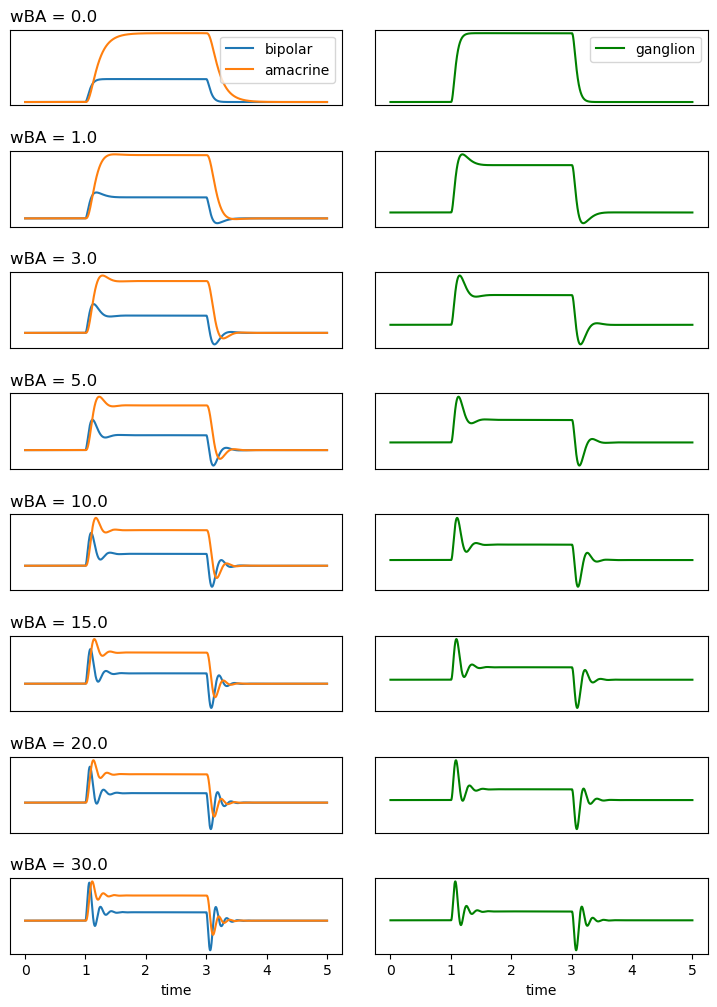

In [12]:
fig = plt.figure()


fig = plt.figure(figsize = (9,12))

fig.subplots_adjust(hspace = 0.6,
                    wspace = 0.1)

gs = fig.add_gridspec(len(vals),2)
for i,val in enumerate(vals): 

    # load output 
    with open(f'{fp}/{param}/{param}_{val}/out_step', 'rb') as handle:
        out_impulse = pickle.load(handle)    


    # plot bc and ac
    ax0 = fig.add_subplot(gs[i,0]) 
    plt.plot(time_step,out_impulse['VB'][50,:], label = 'bipolar')
    plt.plot(time_step,out_impulse['VA'][50,:], label = 'amacrine')
    ax0.set_title(f'wBA = {val}', loc = 'left')

    # plot GC
    ax1 = fig.add_subplot(gs[i,1]) 
    plt.plot(time_step, out_impulse['VG'], color = 'green', label = 'ganglion')


    if i ==0:
        ax0.legend()
        ax1.legend()

    if  i < len(vals)-1:
        ax0.set_xticks([])
        ax1.set_xticks([])
    ax0.set_yticks([])
    ax1.set_yticks([])



ax0.set_xlabel('time')
ax1.set_xlabel('time')


# plot for multiple values of absolute time constants (keep distance between them same)

-> the bigger the time constants the more the response becomes polyphasic 

-> the frequency stays constant 

-> the more the step reponse becomes transient ond oscillating

In [13]:
param = 'tauB'
vals = np.arange(0.03,0.14,0.01)
vals= np.round(vals,4)


Text(0.5, 0, 'time')

<Figure size 640x480 with 0 Axes>

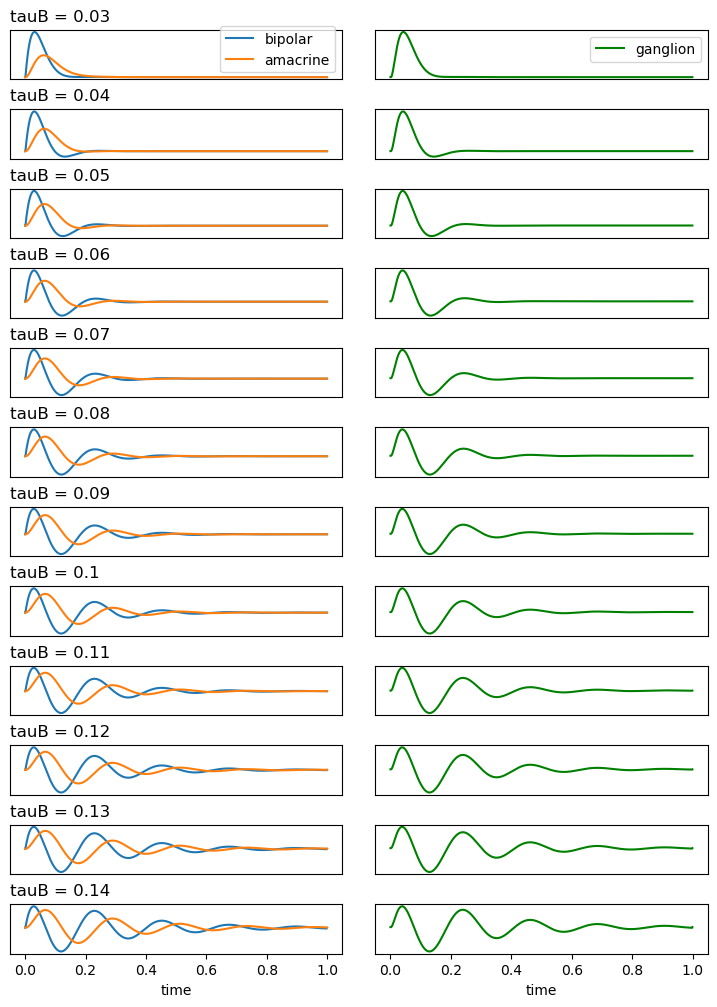

In [14]:
fig = plt.figure()

fig = plt.figure(figsize = (9,12))

fig.subplots_adjust(hspace = 0.6,
                    wspace = 0.1)

amp = []
freq = []
gs = fig.add_gridspec(len(vals),2)
for i,val in enumerate(vals): 

    # load output 
    with open(f'{fp}/{param}/{param}_{val}/out_impulse', 'rb') as handle:
        out_impulse = pickle.load(handle)    


    # plot bc and ac
    ax0 = fig.add_subplot(gs[i,0]) 
    plt.plot(time_impulse,out_impulse['VB'][50,:], label = 'bipolar')
    plt.plot(time_impulse,out_impulse['VA'][50,:], label = 'amacrine')
    ax0.set_title(f'tauB = {val}', loc = 'left')

    # plot GC
    ax1 = fig.add_subplot(gs[i,1]) 
    plt.plot(time_impulse, out_impulse['VG'], color = 'green', label = 'ganglion')
   
    amp.append(np.max(out_impulse['VG']))

    frequency = main_frequency( out_impulse['VG'], 1/params['dt'])
    freq.append(frequency)
    


    if i ==0:
        ax0.legend()
        ax1.legend()

    if  i < len(vals)-1:
        ax0.set_xticks([])
        ax1.set_xticks([])
    ax0.set_yticks([])
    ax1.set_yticks([])



ax0.set_xlabel('time')
ax1.set_xlabel('time')



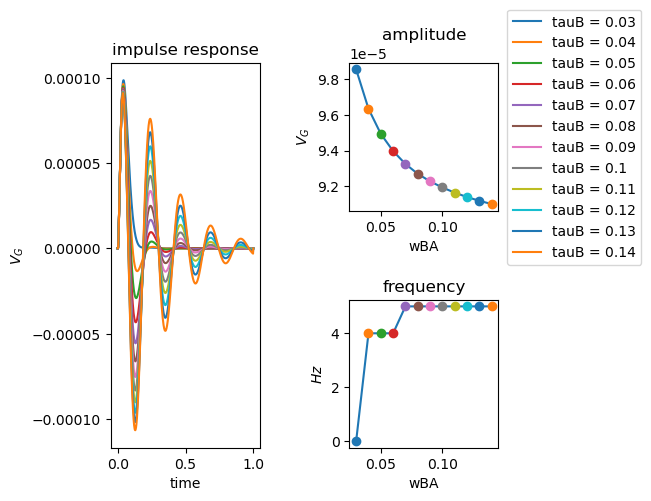

In [17]:
fig = plt.figure(figsize = (5,5))

gs = fig.add_gridspec(2,2)
ax0 = fig.add_subplot(gs[:,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[1,1])

fig.subplots_adjust(hspace = 0.6,
                    wspace = 0.6)

ax1.plot(vals,amp)
ax2.plot(vals,freq)



for i,val in enumerate(vals): 

    # load output 
    with open(f'{fp}/{param}/{param}_{val}/out_impulse', 'rb') as handle:
        out_impulse = pickle.load(handle)    

    ax0.plot(time_impulse, out_impulse['VG'], label = f'tauB = {val}')
    ax1.scatter(val,amp[i], zorder = 10)
    ax2.scatter(val,freq[i], zorder = 10)


    
ax0.set_xlabel('time')
ax0.set_ylabel('$V_{G}$')
ax0.set_title('impulse response')



ax1.set_xlabel('wBA')
ax1.set_ylabel('$V_{G}$')
ax1.set_title('amplitude')


ax2.set_xlabel('wBA')
ax2.set_ylabel('$Hz$')
ax2.set_title('frequency')

fig.legend(loc = 'upper right', bbox_to_anchor = (1.2,1.))


Text(0.5, 0, 'time')

<Figure size 640x480 with 0 Axes>

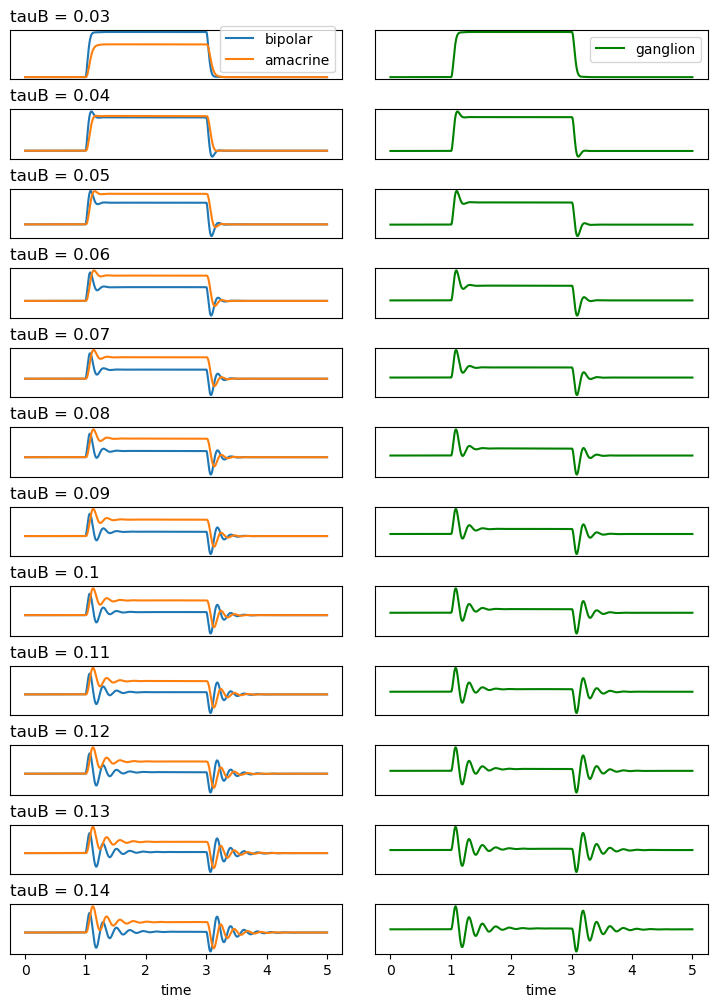

In [16]:
fig = plt.figure()

fig = plt.figure(figsize = (9,12))

fig.subplots_adjust(hspace = 0.6,
                    wspace = 0.1)

gs = fig.add_gridspec(len(vals),2)
for i,val in enumerate(vals): 

    # load output 
    with open(f'{fp}/{param}/{param}_{val}/out_step', 'rb') as handle:
        out_impulse = pickle.load(handle)    


    # plot bc and ac
    ax0 = fig.add_subplot(gs[i,0]) 
    plt.plot(time_step,out_impulse['VB'][50,:], label = 'bipolar')
    plt.plot(time_step,out_impulse['VA'][50,:], label = 'amacrine')
    ax0.set_title(f'tauB = {val}', loc = 'left')

    # plot GC
    ax1 = fig.add_subplot(gs[i,1]) 
    plt.plot(time_step, out_impulse['VG'], color = 'green', label = 'ganglion')


    if i ==0:
        ax0.legend()
        ax1.legend()

    if  i < len(vals)-1:
        ax0.set_xticks([])
        ax1.set_xticks([])
    ax0.set_yticks([])
    ax1.set_yticks([])



ax0.set_xlabel('time')
ax1.set_xlabel('time')


# same for relative distance 

 -> only changes the amplitude 

In [20]:
param = 'tauA'
vals = np.linspace(1.,10,10)
vals

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

1.0 0.09
2.0 0.1
3.0 0.11
4.0 0.12
5.0 0.13
6.0 0.15
7.0 0.18
8.0 0.22
9.0 0.29
10.0 0.4


Text(0.5, 0, 'time')

<Figure size 640x480 with 0 Axes>

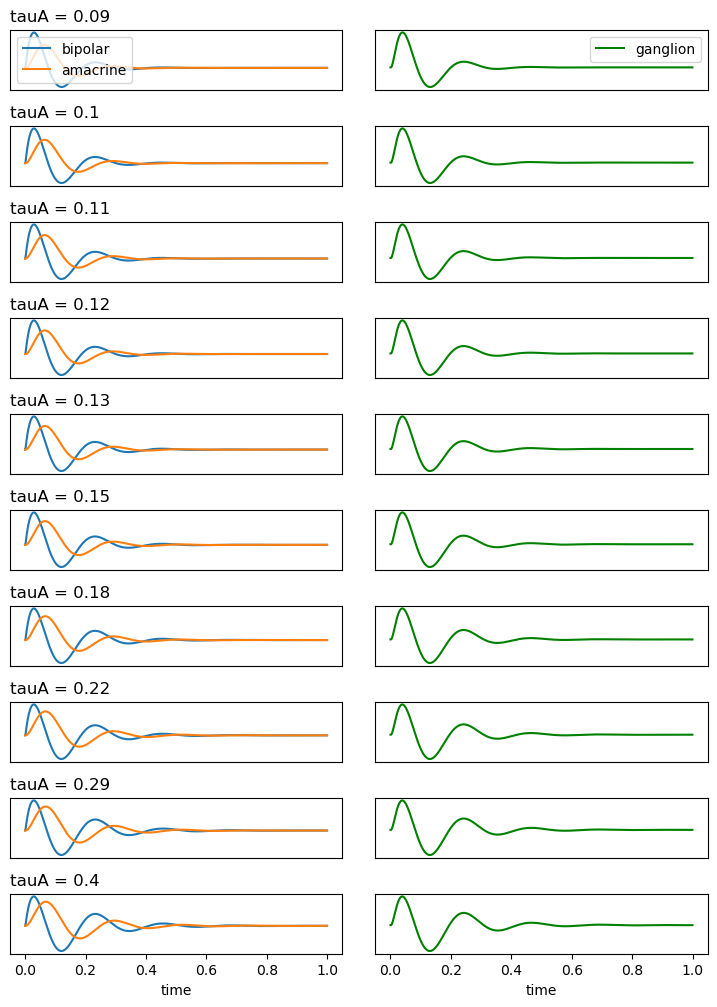

In [21]:
fig = plt.figure()

fig = plt.figure(figsize = (9,12))

fig.subplots_adjust(hspace = 0.6,
                    wspace = 0.1)

amp = []
freq = []
gs = fig.add_gridspec(len(vals),2)
for i,val in enumerate(vals): 

    # load output 
    x = val
    tauB = 0.08
    tauA =  np.round(1/(-x+1/tauB),2)
    print(x,tauA)
    with open(f'{fp}/{param}/{param}_{tauA}/out_impulse', 'rb') as handle:
        out_impulse = pickle.load(handle)    


    # plot bc and ac
    ax0 = fig.add_subplot(gs[i,0]) 
    plt.plot(time_impulse,out_impulse['VB'][50,:], label = 'bipolar')
    plt.plot(time_impulse,out_impulse['VA'][50,:], label = 'amacrine')
    ax0.set_title(f'tauA = {tauA}', loc = 'left')

    # plot GC
    ax1 = fig.add_subplot(gs[i,1]) 
    plt.plot(time_impulse, out_impulse['VG'], color = 'green', label = 'ganglion')


    amp.append(np.max(out_impulse['VG']))

    frequency = main_frequency( out_impulse['VG'], 1/params['dt'])
    freq.append(frequency)
    


    if i ==0:
        ax0.legend()
        ax1.legend()

    if  i < len(vals)-1:
        ax0.set_xticks([])
        ax1.set_xticks([])
    ax0.set_yticks([])
    ax1.set_yticks([])



ax0.set_xlabel('time')
ax1.set_xlabel('time')



1.0 0.09
2.0 0.1
3.0 0.11
4.0 0.12
5.0 0.13
6.0 0.15
7.0 0.18
8.0 0.22
9.0 0.29
10.0 0.4


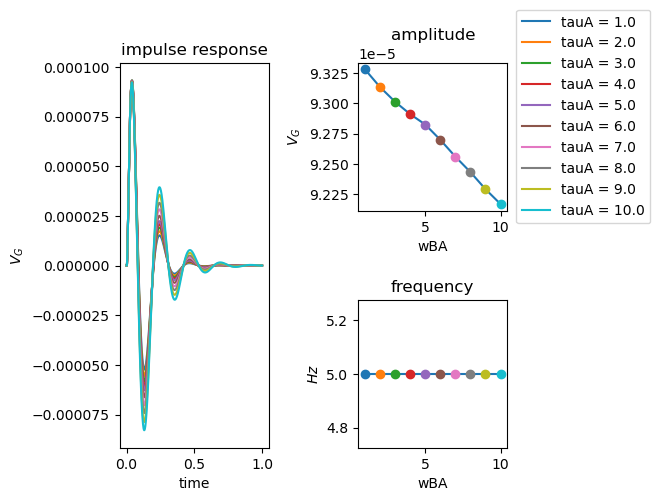

In [23]:
fig = plt.figure(figsize = (5,5))

gs = fig.add_gridspec(2,2)
ax0 = fig.add_subplot(gs[:,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[1,1])

fig.subplots_adjust(hspace = 0.6,
                    wspace = 0.6)

ax1.plot(vals,amp)
ax2.plot(vals,freq)



for i,val in enumerate(vals): 

    # load output 
    x = val
    tauB = 0.08
    tauA =  np.round(1/(-x+1/tauB),2)
    print(x,tauA)
    with open(f'{fp}/{param}/{param}_{tauA}/out_impulse', 'rb') as handle:
        out_impulse = pickle.load(handle)    

    ax0.plot(time_impulse, out_impulse['VG'], label = f'tauA = {val}')
    ax1.scatter(val,amp[i], zorder = 10)
    ax2.scatter(val,freq[i], zorder = 10)


    
ax0.set_xlabel('time')
ax0.set_ylabel('$V_{G}$')
ax0.set_title('impulse response')



ax1.set_xlabel('wBA')
ax1.set_ylabel('$V_{G}$')
ax1.set_title('amplitude')


ax2.set_xlabel('wBA')
ax2.set_ylabel('$Hz$')
ax2.set_title('frequency')

fig.legend(loc = 'upper right', bbox_to_anchor = (1.2,1.))


Text(0.5, 0, 'time')

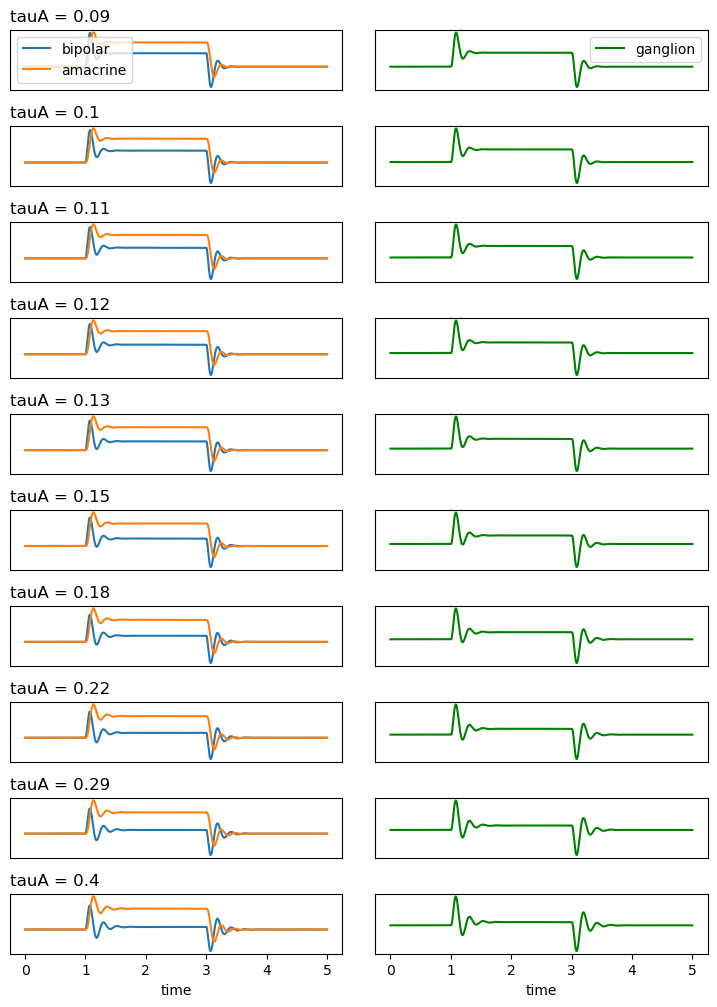

In [178]:
fig = plt.figure(figsize = (9,12))

fig.subplots_adjust(hspace = 0.6,
                    wspace = 0.1)

gs = fig.add_gridspec(len(vals),2)
for i,val in enumerate(vals): 

    # load output 
    # load output 
    x = val
    tauB = 0.08
    tauA =  np.round(1/(-x+1/tauB),2)

    with open(f'{fp}/{param}/{param}_{tauA}/out_step', 'rb') as handle:
        out_impulse = pickle.load(handle)    


    # plot bc and ac
    ax0 = fig.add_subplot(gs[i,0]) 
    plt.plot(time_step,out_impulse['VB'][50,:], label = 'bipolar')
    plt.plot(time_step,out_impulse['VA'][50,:], label = 'amacrine')
    ax0.set_title(f'tauA = {tauA}', loc = 'left')

    # plot GC
    ax1 = fig.add_subplot(gs[i,1]) 
    plt.plot(time_step, out_impulse['VG'], color = 'green', label = 'ganglion')


    if i ==0:
        ax0.legend()
        ax1.legend()

    if  i < len(vals)-1:
        ax0.set_xticks([])
        ax1.set_xticks([])
    ax0.set_yticks([])
    ax1.set_yticks([])



ax0.set_xlabel('time')
ax1.set_xlabel('time')
